# Exploratory Data Analysis for Click-Through Rate Prediction

The dataset was provided by the mobile advertising company Avazu as part of a [Kaggle competition](https://www.kaggle.com/competitions/avazu-ctr-prediction/overview)

*Dataset Citation: Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction*


# What is Click Through Rate Prediction

In today's digital age, online advertising reigns supreme. Its effectiveness hinges on understanding user behavior and predicting their actions. This is where click-through rate (CTR), the probability of a user clicking on an ad, becomes crucial. Accurately predicting CTR empowers advertisers to optimize campaigns, maximize reach, and deliver targeted messaging.

This exploratory data analysis (EDA) delves into the Avazu dataset, a benchmark resource for honing CTR prediction models. By scrutinizing its intricacies, we aim to gain valuable insights into the factors influencing user clicks on online advertisements. Through this exploration, we can uncover hidden patterns, assess feature importance, and ultimately, pave the way for the development of robust models that can effectively predict user engagement and propel advertising campaigns to new heights.

## Standard Package Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
contentRoot = '/content/drive/MyDrive/Github/machinelearning/click-through-prediction'

## Standard functions utilized thoughout the notebook

In [ ]:
def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)

# Data Description

**File descriptions**
* train - Training set. 10 days of click-through data, ordered chronologically. Non-clicks and clicks are subsampled according to different strategies.
* test - Test set. 1 day of ads to for testing model predictions.

**Data fields**
* id: ad identifier
* click: 0/1 for non-click/click
* hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* C1 -- anonymized categorical variable
* banner_pos
* site_id
* site_domain
* site_category
* app_id
* app_domain
* app_category
* device_id
* device_ip
* device_model
* device_type
* device_conn_type
* C14-C21 -- anonymized categorical variables

In [ ]:
#Load the first 100MM rows from the dataset
df = pd.read_csv('{}/data/train.gz'.format(contentRoot))
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


# Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


## Check for NaN values

There are no empty values in the dataset

In [ ]:
check_null(df)

id                  0.0
click               0.0
hour                0.0
C1                  0.0
banner_pos          0.0
site_id             0.0
site_domain         0.0
site_category       0.0
app_id              0.0
app_domain          0.0
app_category        0.0
device_id           0.0
device_ip           0.0
device_model        0.0
device_type         0.0
device_conn_type    0.0
C14                 0.0
C15                 0.0
C16                 0.0
C17                 0.0
C18                 0.0
C19                 0.0
C20                 0.0
C21                 0.0
dtype: float64

## Transform the hour column into a usable date format

In [ ]:
df['datetime'] = pd.to_datetime(df['hour'],format = '%y%m%d%H')

## Let's look at the distribution of clicks across the dataset

<Axes: title={'center': 'Distribution of Clicks by Hour'}, xlabel='Date', ylabel='Number of Clicks'>

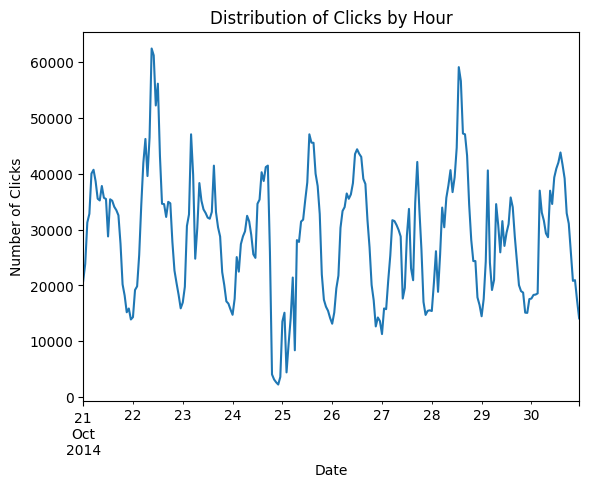

In [ ]:
clicks_over_time = df.groupby('datetime')['click'].sum()
clicks_over_time.plot(title='Distribution of Clicks by Hour',
                      xlabel = 'Date', ylabel='Number of Clicks')

The data follows a daily pattern by hour, with some anomalies on certain days. Based on this plot, it might make sense to extract a categorical variable with just `hour` to capture this cyclical pattern. We may retain `datetime` as another feature.

The other important observation is that the click might depend on the day of the week. We may want to extract another feature `day-of-week-hour` to represent this relationship.

## Let's analyze the correlation of CTR to other dimensions

In [ ]:
df['day_of_week'] = df['datetime'].dt.day_name()

In [ ]:
def calculate_ctr(data, dimension):
  df_dimension = data[[dimension,'click']].groupby([dimension])\
                     .count().reset_index()\
                     .rename(columns={'click': 'impressions'})
  df_click = data[data['click'] == 1]
  df_dimension['clicks'] = df_click[[dimension,'click']].groupby([dimension])\
                              .count().reset_index()['click']
  df_dimension['CTR'] = df_dimension['clicks']/df_dimension['impressions']*100
  return df_dimension

### CTR By Day of Week

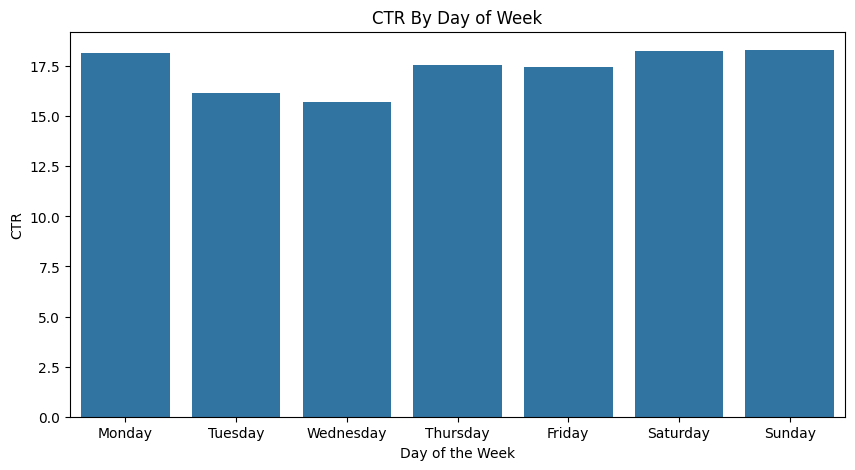

In [ ]:
df_day_of_week = calculate_ctr(df, 'day_of_week')

plt.figure(figsize=(10,5))
sns.barplot(y='CTR', x='day_of_week', data=df_day_of_week,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of the Week')
plt.title('CTR By Day of Week');

There is not much of a variation in CTR across days and it hovers around 15 - 17%

### CTR By Banner Position

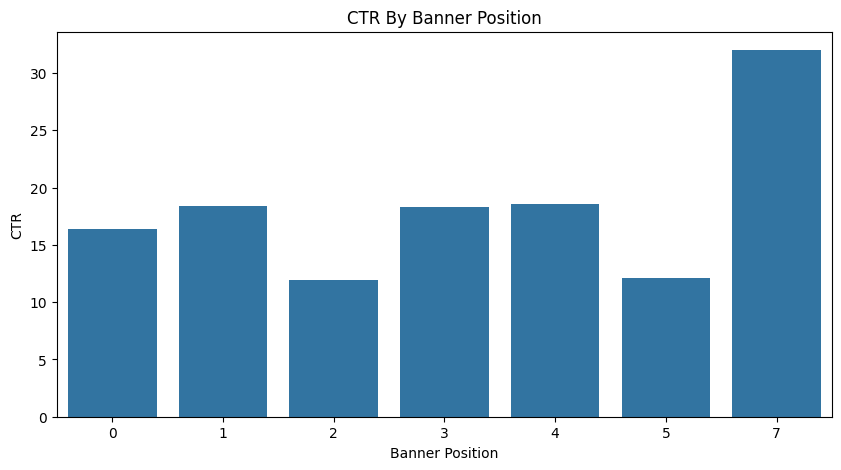

In [ ]:
df_banner_pos = calculate_ctr(df, 'banner_pos')
plt.figure(figsize=(10,5))
sns.barplot(y='CTR', x='banner_pos', data=df_banner_pos)
plt.xlabel('Banner Position')
plt.title('CTR By Banner Position');

### CTR By C1

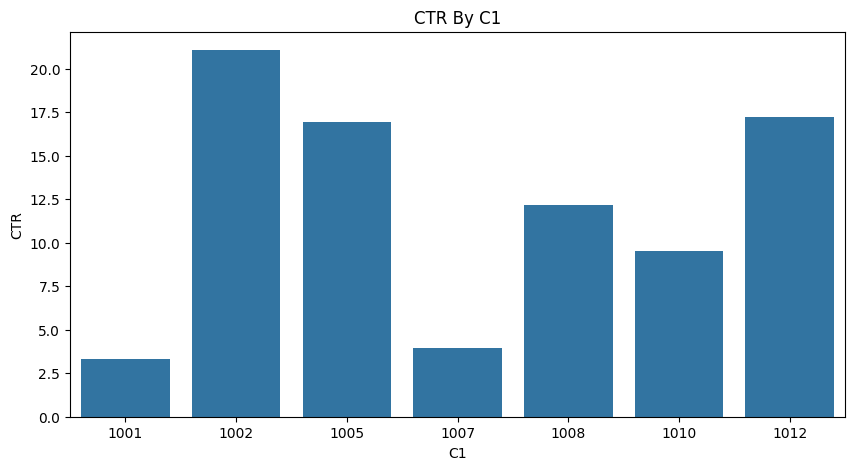

In [ ]:
df_C1 = calculate_ctr(df, 'C1')
plt.figure(figsize=(10,5))
sns.barplot(y='CTR', x='C1', data=df_C1)
plt.xlabel('C1')
plt.title('CTR By C1');

### CTR By Device Type

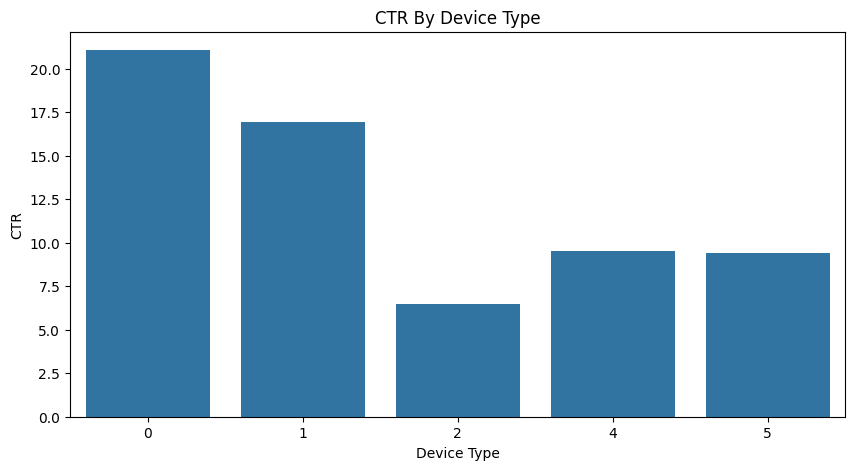

In [ ]:
df_device_type = calculate_ctr(df, 'device_type')
plt.figure(figsize=(10,5))
sns.barplot(y='CTR', x='device_type', data=df_device_type)
plt.xlabel('Device Type')
plt.title('CTR By Device Type');

### CTR by Device Connection Type

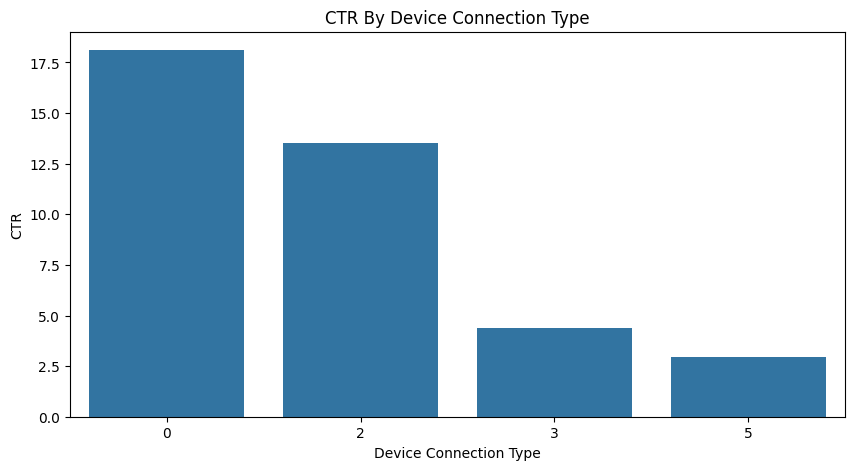

In [ ]:
df_device_conn_type = calculate_ctr(df, 'device_conn_type')
plt.figure(figsize=(10,5))
sns.barplot(y='CTR', x='device_conn_type', data=df_device_conn_type)
plt.xlabel('Device Connection Type')
plt.title('CTR By Device Connection Type');

This chart indicates that the CTR of Connection Type 0 is close to the overall CTR, so it might be true that Type 0 is the dominant type. Let's verify that.

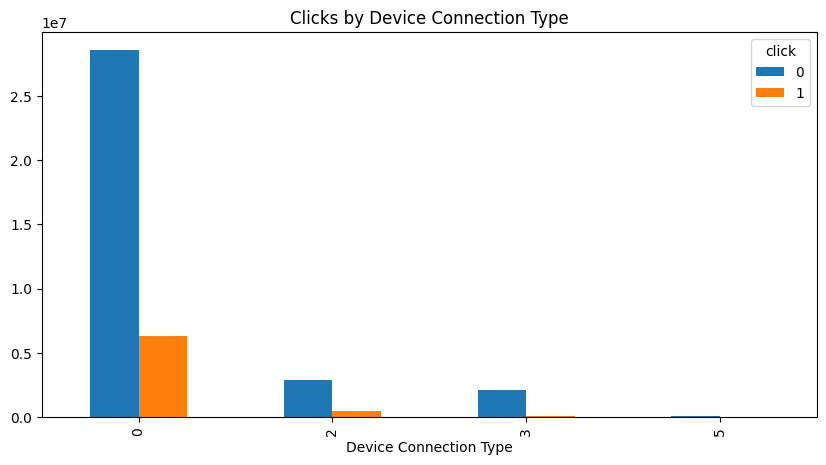

In [ ]:
df.groupby(['device_conn_type', 'click']).size()\
    .unstack().plot(kind='bar',
                    figsize=(10,5),
                    title='Clicks by Device Connection Type',
                    xlabel='Device Connection Type');

It is true that most of the impressions are for `device_conn_type = 0`

## Let's check the cardinality of each column in the dataset

In [ ]:
df.apply(pd.Series.nunique)

id                  40428967
click                      2
hour                     240
C1                         7
banner_pos                 7
site_id                 4737
site_domain             7745
site_category             26
app_id                  8552
app_domain               559
app_category              36
device_id            2686408
device_ip            6729486
device_model            8251
device_type                5
device_conn_type           4
C14                     2626
C15                        8
C16                        9
C17                      435
C18                        4
C19                       68
C20                      172
C21                       60
datetime                 240
dtype: int64

The following observations can be made:
* id: Unique for each row, no duplicates
* click: 0/1
* hour/datetime: 240 unique values (24 hours * 10 days)
* C1, banner_pos, device_type, device_conn_type, C15, C16, C18: These have single digit cardinality. May be used as is.
* site_category: Cardinality of 26, but still makes sense to retain as-is
* site_id, site_domain, app_id, device_model, C14: These have high cardinality with 999 < x < 9999 cardinality. These need further exploration and we may analyze the distribution of data.
* app_domain: Cardinality of 559. There might be an opportunity to reduce this but it is also acceptable as-is.
* app_category: Cardinality of 36, but makes sense to retain as-is
* device_id: Very high cardinality of > 2MM. Might want to discard.
* device_ip: Very high cardinality of > 6MM. Might want to discard.
* C17, C19, C20, C21: Since these are anonymized, further exploration is necessary

## Analyzing features that have between 1000 and 10000 cardinality

For each of these features (app_id, app_domain, device_model, C14), let us plot the distribution of values. We are interested in seeing if:
* Are there a set of values that represent the long tail, and can we focus only on the head
* Are there opportunities to bin the data to reduce the cardinality

### Let's write a function to make this analysis easy

We will write a function that accepts a series, looks at the unique values that represent most of the data, and tells us how many of them make up a threshold percentage. For example, we can ask the function to return us the count of top values that make up 99% of the data. This is useful in reducing cardinality by eliminating the "long tail"

In [ ]:
def count_head_values_representing_threshold(series, threshold):
  series_df = pd.DataFrame(series.value_counts().sort_values(ascending=False))
  series_df.columns = ['value_count']
  # Calculating cumulative sum
  series_df['cum_sum'] = series_df['value_count'].cumsum()
  # Calculating cumulative percentage
  series_df['cum_perc'] =  100*series_df['cum_sum']/series_df['value_count'].sum()
  return series_df[series_df['cum_perc'] < threshold].shape[0]

### Let's take a look at app_id

In [ ]:
count_head_values_representing_threshold(df['app_id'], 99)

620

620 `app_id`s represent 99% of the data. This is a good number, we can use these 620 as our feature set, and the rest (~7900 values) can be lumped into an `app_id` called `Others`

### Let's take a look at site_id & site_domain

In [ ]:
count_head_values_representing_threshold(df['site_id'], 99)

820

In [ ]:
count_head_values_representing_threshold(df['site_domain'], 99)

650

820 unique `site_id`s and 650 `site_domain`s represent 99% of the data. We may classify all the other values as `Others` to reduce cardinality.

### Let's take a look at device_model

In [ ]:
count_head_values_representing_threshold(df['device_model'], 99)

2524

In [ ]:
count_head_values_representing_threshold(df['device_model'], 95)

1141

`device_model` does not look like a good candidate to pick head values. We may consider using feature hashing to reduce the cardinality for this feature.

### Finally, let's look at C14

In [ ]:
df['C14'].value_counts()

4687     948215
21611    907004
21189    765968
21191    765092
19771    730238
          ...  
23425         1
23982         1
7648          1
23977         1
23679         1
Name: C14, Length: 2626, dtype: int64

In [ ]:
count_head_values_representing_threshold(df['C14'], 95)

623

In [ ]:
count_head_values_representing_threshold(df['C14'], 99)

1201

C14 is an anonymized categorical feature, and it is hard to decipher what it represents. With a 99% threshold, there are still 1201 unique values to consider, so we can use 95% to represent 623 unique `C14`s

## Analyzing the anonymized categorical columns C17, C19, C20, C21

### C17

In [ ]:
df['C17'].value_counts()

1722    4513492
2424    1531071
2227    1473105
1800    1190161
423      948215
         ...   
2746          4
1253          3
1516          1
2752          1
2704          1
Name: C17, Length: 435, dtype: int64

`C17` has 435 unique values, and since it is an anonymized column, further transformation does not seem possible.

### C17

In [ ]:
df['C19'].value_counts()

35      12170630
39       8829426
167      3145695
161      1587765
47       1451708
          ...   
1447         161
1195         132
545          117
677            8
1959           2
Name: C19, Length: 68, dtype: int64

`C19` do not show any potential for transformation and only has 68 unique values. Since values are anonymized we cannot analyze what they semantically refer to. Recommendation would be to keep the column as-is.

### C20

In [ ]:
df['C20'].value_counts()

-1         18937918
 100084     2438478
 100148     1794890
 100111     1716733
 100077     1575495
             ...   
 100006           5
 100187           3
 100209           2
 100008           2
 100198           1
Name: C20, Length: 172, dtype: int64

A lot of rows have `C20` as -1. However, this observation does not seem actionable, so we will ignore that.

### C21

In [ ]:
df['C21'].nunique()

60

`C21` only has 60 unique values which are spread across rows, so we will retain `C21` as-is

# Summary

As part of data understanding, the following angles were explored:
* Do clicks vary by specific hours of the day or day of the week?
* What is the cardinality of various columns in the dataset?
* Which columns are likely to have minimal impact on the final model?
* What factors do Click-through-Rate (calculated as clicks/impressions*100) depend on?

The answers to these questions were identified in this notebook.